# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/ASUS/Desktop/FMI/Licenta OB/Overall Code/packtpub-src/csv/FB2012-2019.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-29,31.480000,31.690001,28.650000,28.840000,28.840000,78063400
1,2012-05-30,28.700001,29.549999,27.860001,28.190001,28.190001,57267900
2,2012-05-31,28.549999,29.670000,26.830000,29.600000,29.600000,111639200
3,2012-06-01,28.889999,29.150000,27.389999,27.719999,27.719999,41855500
4,2012-06-04,27.200001,27.650000,26.440001,26.900000,26.900000,35230300


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1755,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
1756,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
1757,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
1758,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
1759,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14843300


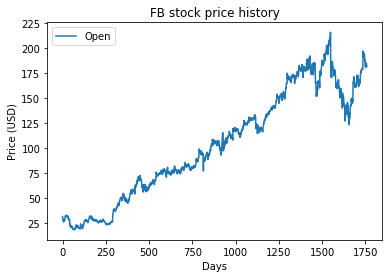

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

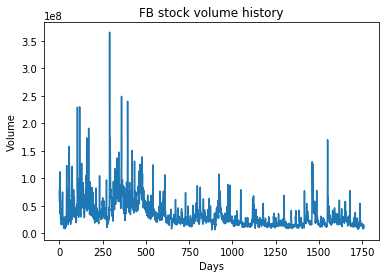

In [6]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [8]:
#! pip install keras

In [9]:
#! pip install np_utils

In [10]:
#! pip install tensorflow

In [11]:
#! pip install numpy --upgrade --user

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression

print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


Checking GPU available []


In [13]:
from keras import losses

In [14]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [15]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

In [38]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 1408 352


In [39]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [40]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [41]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)


length of time-series i/o (1348, 60, 5) (1348,)



length of time-series i/o (292, 60, 5) (292,)


In [42]:
type(x_t)
x_t.shape
x_t[:, :, :1].shape

(1340, 60, 1)

In [43]:
print(x_t.shape)

(1340, 60, 5)


In [48]:
x_t = x_t[:, :, :1]
x_t.reshape((x_t.shape[0], x_t.shape[1]))



array([[0.08100103, 0.06419634, 0.0632896 , ..., 0.01166657, 0.0058635 ,
        0.00906728],
       [0.06419634, 0.0632896 , 0.06534485, ..., 0.0058635 , 0.00906728,
        0.00773742],
       [0.0632896 , 0.06534485, 0.05512907, ..., 0.00906728, 0.00773742,
        0.00858369],
       ...,
       [0.9334462 , 0.92854988, 0.91960353, ..., 0.97455122, 0.97031984,
        0.96246151],
       [0.92854988, 0.91960353, 0.91374001, ..., 0.97031984, 0.96246151,
        0.96844586],
       [0.91960353, 0.91374001, 0.88508737, ..., 0.96246151, 0.96844586,
        0.97285866]])

In [49]:
x_t.shape

(1340, 60, 1)

In [47]:
benchmark_model = LinearRegression()
benchmark_model.fit(x_t, y_t)
y_test_pred = benchmark_model.predict(x_test)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error", error, y_pred.shape, y_test_t.shape)

y_pred_orig = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_test_t_orig = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

In [ ]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(y_test_t_orig)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [ ]:
# do gridsearch, put logging into
# what overfit would mean here?
# read lstm AK
# how to appreciate how good is the prediction?

# sentiment analysis for stock prediction ? X

